In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

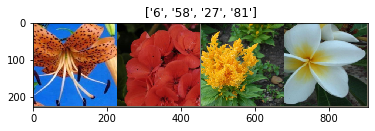

In [3]:
data_dir = 'flower_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)
    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_loss_arr = []
    epoch_acc_arr = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            epoch_loss_arr.append(epoch_loss)
            epoch_acc_arr.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_arr, epoch_acc_arr

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
def test_model(model, criterion):
    model.eval()
                
    running_loss = 0.0
    running_corrects = 0
    index = 0
            
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
                    
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        index += 1
        
        if (index%100 == 0):
            print('{}/{} completed'.format(index,dataset_sizes['test']))
                
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']
    
            
    print('test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
epoch_loss_arr = []
epoch_acc_arr = []

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft, epoch_loss_arr, epoch_acc_arr = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=10)


Epoch 0/9
----------
train Loss: 4.5159 Acc: 0.0480
val Loss: 3.0623 Acc: 0.2794

Epoch 1/9
----------
train Loss: 3.3322 Acc: 0.2422
val Loss: 1.8264 Acc: 0.5461

Epoch 2/9
----------
train Loss: 2.4500 Acc: 0.4275
val Loss: 1.2101 Acc: 0.6725

Epoch 3/9
----------
train Loss: 1.9703 Acc: 0.5265
val Loss: 0.8540 Acc: 0.7686

Epoch 4/9
----------
train Loss: 1.5720 Acc: 0.6471
val Loss: 0.7919 Acc: 0.7745

Epoch 5/9
----------
train Loss: 1.3664 Acc: 0.6882
val Loss: 0.6283 Acc: 0.8284

Epoch 6/9
----------
train Loss: 1.1436 Acc: 0.7569
val Loss: 0.6183 Acc: 0.8255

Epoch 7/9
----------
train Loss: 0.8969 Acc: 0.8304
val Loss: 0.4991 Acc: 0.8696

Epoch 8/9
----------
train Loss: 0.8130 Acc: 0.8510
val Loss: 0.4435 Acc: 0.8755

Epoch 9/9
----------
train Loss: 0.7667 Acc: 0.8657
val Loss: 0.4114 Acc: 0.8882

Training complete in 57m 38s
Best val acc: 0.888235


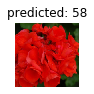

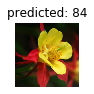

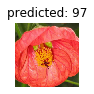

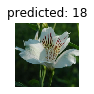

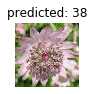

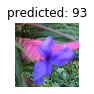

In [8]:
visualize_model(model_ft)

In [9]:
test_model(model_ft, criterion)

100/6149 completed
200/6149 completed
300/6149 completed
400/6149 completed
500/6149 completed
600/6149 completed
700/6149 completed
800/6149 completed
900/6149 completed
1000/6149 completed
1100/6149 completed
1200/6149 completed
1300/6149 completed
1400/6149 completed
1500/6149 completed
test Loss: 0.5152 Acc: 0.8702
